In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import cv2
from numpy import newaxis

In [2]:
dataPath = '/content/drive/MyDrive/Datasets/'
filename = 'cattu.jpg'
img = cv2.imread(os.path.join(dataPath,filename))

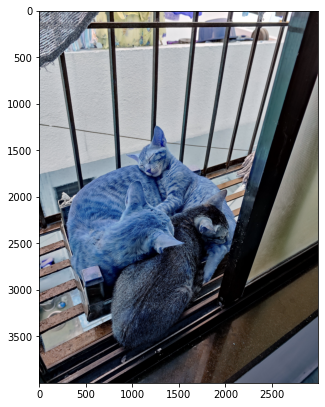

In [3]:
plt.figure(figsize=(5,20))
plt.imshow(img)

# Convolutional Layer

In [4]:
width , height , channels = img.shape

In [5]:
img = np.array(img)
img = img / 255.

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

conv = tf.keras.layers.Conv2D(filters=20,kernel_size=7,strides = 1,padding = "SAME",activation = "relu",input_shape = (1,4000,3000,3))

In [7]:
conv_output = conv(img.reshape(1,4000,3000,3))

In [8]:
conv_output.shape

TensorShape([1, 4000, 3000, 20])

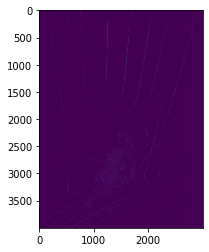

In [9]:
plt.imshow(conv_output[0,:,:,2])

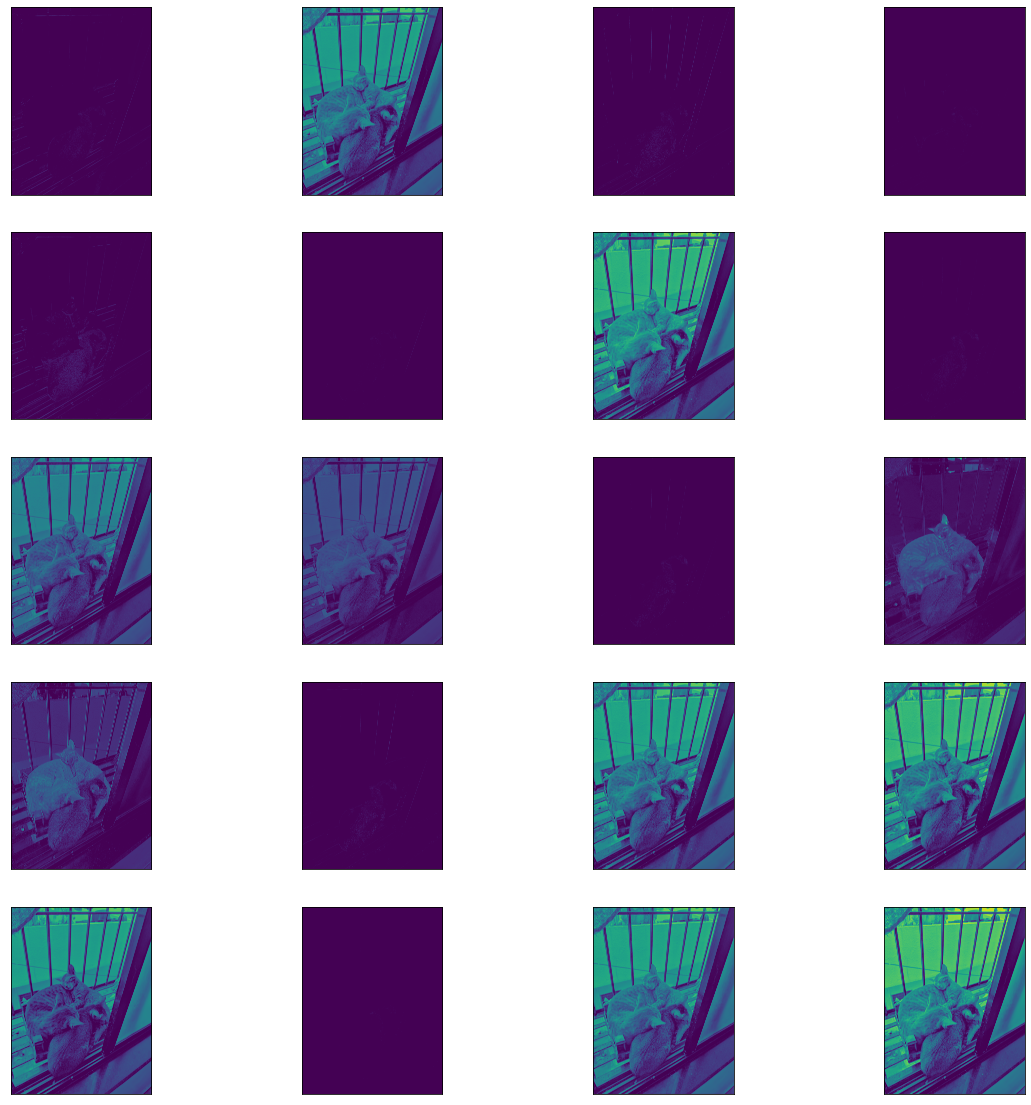

In [10]:
fig = plt.figure(figsize=(20,20))

for it in range(20):
  ax = fig.add_subplot(5,4,it+1,xticks=[],yticks=[])
  plt.imshow(conv_output[0,:,:,it])
  it+=1

# Max Pooling

In [11]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=12)

In [12]:
outputMaxPool = max_pool(img.reshape(1,4000,3000,3))

In [13]:
outputMaxPool.shape

TensorShape([1, 333, 250, 3])

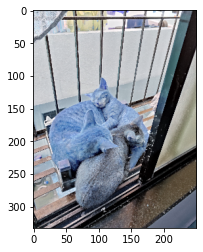

In [14]:
plt.imshow(outputMaxPool[0])

# Depth Wise Pooling

In [15]:
class DepthMaxPool(tf.keras.layers.Layer):
  def __init__(self,pool_size,strides =None , padding = "VALID",**kwargs):
      super().__init__(**kwargs)
      if strides is None:
        strides = pool_size
      self.pool_size = pool_size
      self.strides = strides
      self.padding = padding
  
  def call(self,inputs):
    return tf.nn.max_pool(inputs,
                          ksize = (1,1,1,self.pool_size),
                          strides =(1,1,1,self.pool_size),
                          padding = self.padding)

In [16]:
depth_pool = DepthMaxPool(3)

In [17]:
# Depthwise max pooling is currently only implemented for CPU devices
# max_depth_pool_image=depth_pool(img.reshape(1,4000,3000,3))

In [18]:
#max_depth_pool_image.shape

In [19]:
#Plot the output for the 1st Image
#plt.imshow(max_depth_pool_image[0,...,0])

# Lambda function for Max Depth Pooling


* tf.nn.max_pool() function, and specify the
kernel size and strides as 4-tuples. The first three values of each should be 1: this indi‐
cates that the kernel size and stride along the batch, height and width dimensions
shoud be 1. The last value should be whatever kernel size and stride you want along
the depth dimension, for example 3 (this must be a divisor of the input depth; for
example, it will not work if the previous layer outputs 20 feature maps, since 20 is not
a multiple of 3).



In [20]:
depth_pool = tf.keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X , ksize = (1,1,1,3) , strides = (1,1,1,3),padding="VALID"))

In [21]:
# Depthwise max pooling is currently only implemented for CPU devices
# max_depth_pool_lambda_output = depth_pool(img.reshape(1,4000,3000,3))

In [22]:
#plt.imshow(max_depth_pool_lambda_output[0,...,0])

# Average Pooling

In [23]:
avg_pool = tf.keras.layers.AvgPool2D(pool_size = 2)
output_avg = avg_pool(img.reshape(1,4000,3000,3))

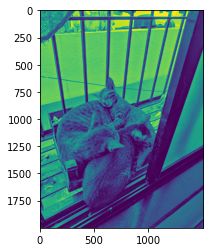

In [24]:
plt.imshow(output_avg[0,...,0])

In [25]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
global_avg_pool(img.reshape(1,4000,3000,3))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.3939392 , 0.4151348 , 0.44901928]], dtype=float32)>

# MNIST with a CNN

In [26]:
(X_train_full,y_train_full) , (X_test , y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train , X_valid = X_train_full[:-5000] , X_train_full[-5000:]
y_train , y_valid = y_train_full[:-5000] , y_train_full[-5000:]

X_mean = X_train.mean(axis = 0 , keepdims=True)
X_std = X_train.std(axis = 0,keepdims=True) + 1e-7
X_train = (X_train - X_mean)/X_std
X_valid = (X_valid - X_mean)/X_std
X_test = (X_test - X_mean)/ X_std

X_train = X_train[...,np.newaxis]
X_valid = X_valid[...,np.newaxis]
X_test = X_test[...,np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


In [27]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_size = 3, activation = 'relu',padding = "SAME")

model = tf.keras.models.Sequential([DefaultConv2D(filters=64,kernel_size = 7,input_shape = [28,28,1]),
                                    tf.keras.layers.MaxPooling2D(pool_size = 2),
                                    DefaultConv2D(filters = 128),
                                    DefaultConv2D(filters = 128),
                                    tf.keras.layers.MaxPooling2D(pool_size = 2),
                                    DefaultConv2D(filters=256),
                                    DefaultConv2D(filters=256),
                                    tf.keras.layers.MaxPooling2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(units=128,activation = 'relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(units = 64,activation = 'relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(units = 10,activation = 'softmax'),                                        
])

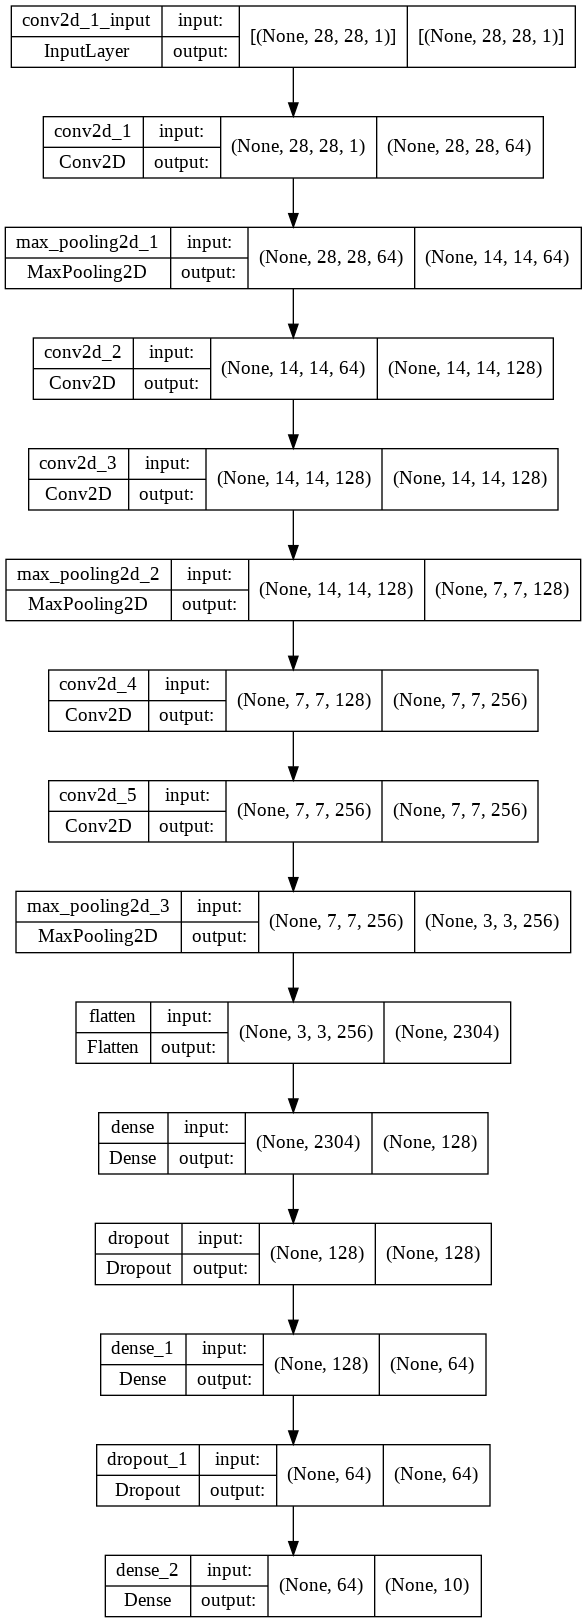

In [28]:
tf.keras.utils.plot_model(model,"ModelCNN1.png",show_shapes = True)

In [29]:
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'nadam',metrics = ['accuracy'])
history = model.fit(X_train,y_train,epochs = 10,validation_data = (X_valid,y_valid))
score = model.evaluate(X_test,y_test)

Epoch 1/10
1719/1719 [==============================] - 19s 9ms/step - loss: 0.7138 - accuracy: 0.7508 - val_loss: 0.3723 - val_accuracy: 0.8706
Epoch 2/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4196 - accuracy: 0.8591 - val_loss: 0.3461 - val_accuracy: 0.8748
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3651 - accuracy: 0.8780 - val_loss: 0.2898 - val_accuracy: 0.8948
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3354 - accuracy: 0.8881 - val_loss: 0.2923 - val_accuracy: 0.8946
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3094 - accuracy: 0.8949 - val_loss: 0.2960 - val_accuracy: 0.8946
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2936 - accuracy: 0.9021 - val_loss: 0.3054 - val_accuracy: 0.8954
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2790 - accuracy: 0.9057 - val_loss: 0.3043 - val_ac

# ReseNet34

In [30]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_size=3,strides = 1,padding = "SAME",use_bias = False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [31]:
model = tf.keras.models.Sequential()
model.add(DefaultConv2D(64,kernel_size = 7,strides = 2,input_shape = [224,224,3]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = 3,strides = 2,padding = "SAME"))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters,strides = strides))
  prev_filters  = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation = "softmax"))

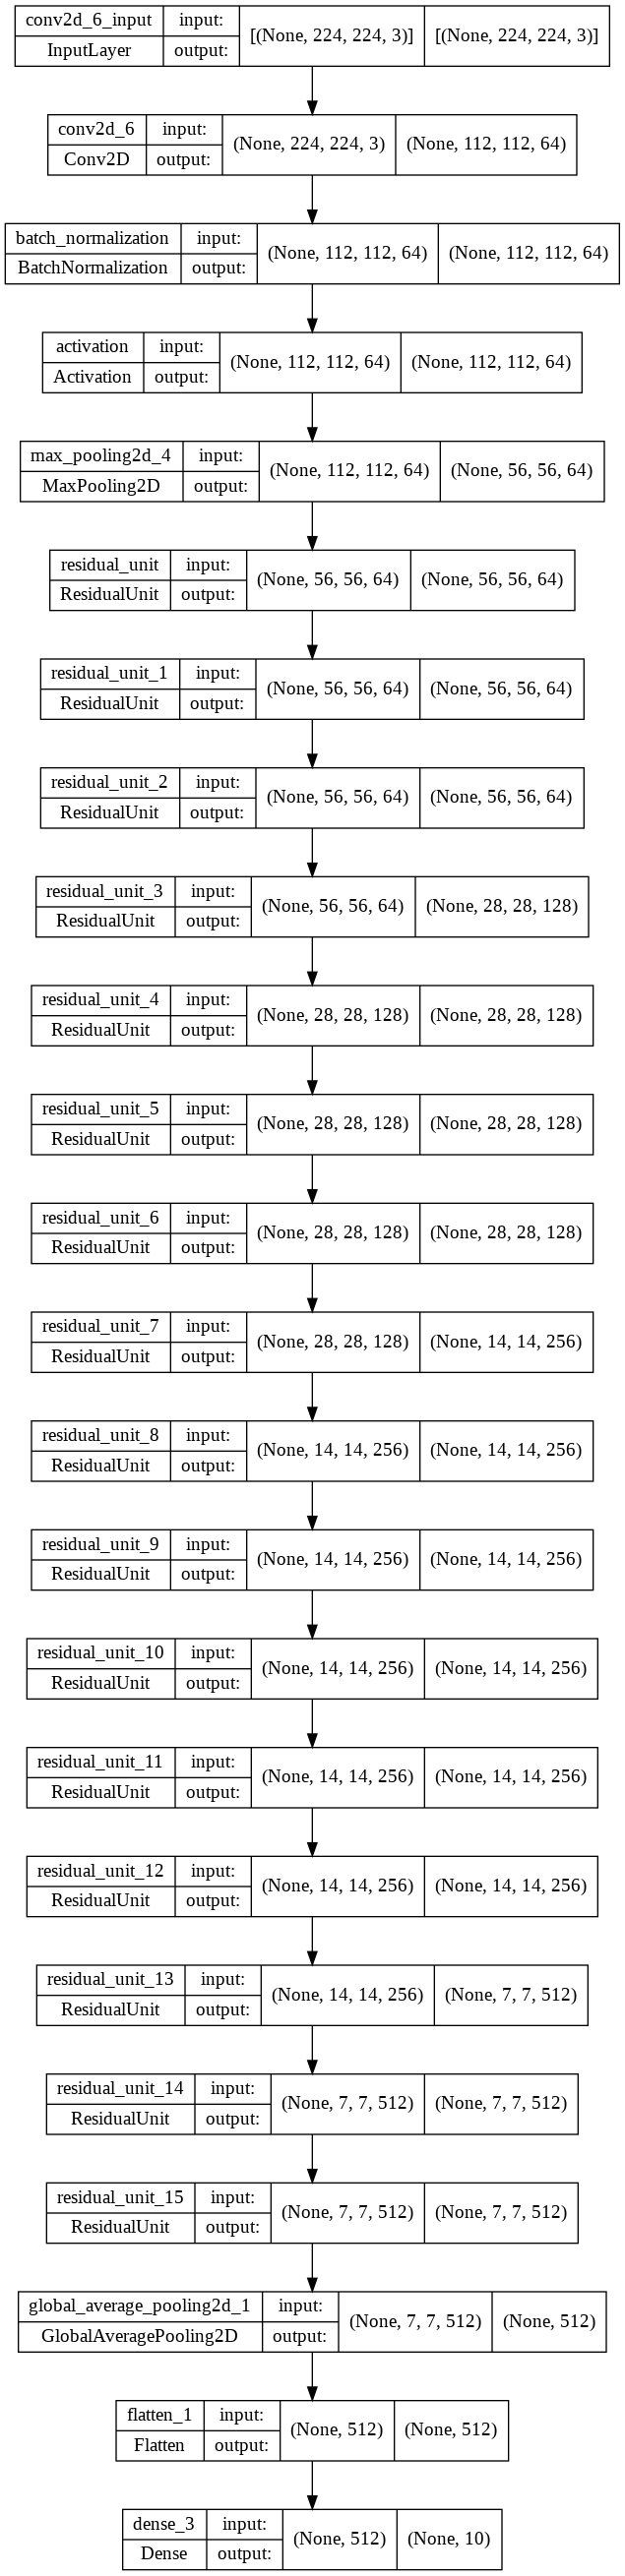

In [32]:
tf.keras.utils.plot_model(model,"ModelCNN1.png",show_shapes = True)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

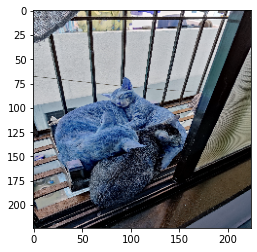

In [34]:
image_resized = tf.image.resize(img,[224,224],method = 'bilinear')
plt.imshow(image_resized)

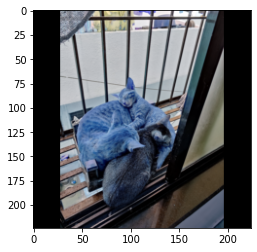

In [35]:
image_resized = tf.image.resize_with_pad(img,224,224,antialias = True)
plt.imshow(image_resized)

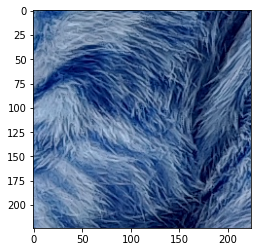

In [36]:
image_resized = tf.image.resize_with_crop_or_pad(img,224,224)
plt.imshow(image_resized)

# Pretrained Model

In [37]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 1s 0us/step


In [38]:
image_resized = tf.image.resize(img,[224,224],method = 'bilinear')

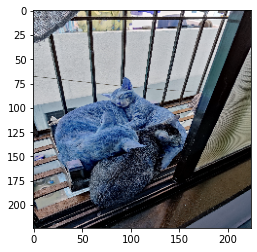

In [39]:
plt.imshow(image_resized)

In [40]:
image_resized.shape

TensorShape([224, 224, 3])

In [41]:
image_resized.dtype

tf.float32

In [42]:
image_resized = image_resized.numpy()

In [43]:
inputs = tf.keras.applications.resnet50.preprocess_input(image_resized.reshape(1,224,224,3))
y_proba = model.predict(inputs)

In [44]:
y_proba.shape

(1, 1000)

In [45]:
top_K = tf.keras.applications.resnet50.decode_predictions(y_proba, top=3)
print(top_K)
# print("Image #{}".format(image_index))
#     for class_id, name, y_proba in top_K[image_index]:
#         print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
#     print()

49152/35363 [=========================================] - 0s 0us/step
[[('n04404412', 'television', 0.08130252), ('n03782006', 'monitor', 0.07383318), ('n03196217', 'digital_clock', 0.066431805)]]


# Pretrained Model For Transfer learning

In [46]:
import tensorflow_datasets as tfds

In [47]:
dataset , info = tfds.load("tf_flowers",as_supervised=True,with_info = True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [48]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [49]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [50]:
class_names = info.features["label"].names

In [51]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [52]:
n_classes = info.features["label"].num_classes

In [53]:
n_classes

5

In [54]:
dataset_size = info.splits["train"].num_examples

In [55]:
dataset_size

3670

In [56]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

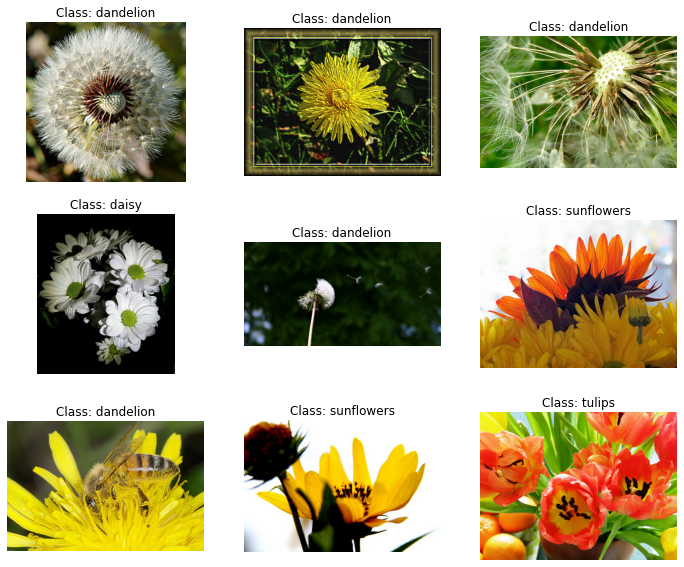

In [57]:
plt.figure(figsize = (12,10))
index = 0
for image , label in train_set_raw.take(9):
  index += 1
  plt.subplot(3,3,index)
  plt.imshow(image)
  plt.title("Class: {}".format(class_names[label]))
  plt.axis("off")


# Basic Processing

In [58]:
def preprocess(image,label):
  resized_image = tf.image.resize(image,[224,224])
  final_image = tf.keras.applications.xception.preprocess_input(resized_image)
  return final_image,label

In [59]:
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0],shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop : bottom_crop , left_crop : right_crop]

def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0],shape[1]]) * 90 // 1000
  return tf.image.random_crop(image,[min_dim,min_dim,3])

def preprocess(image,label,randomize=False):
  if randomize:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    cropped_image =central_crop(image)
  
  resized_image =tf.image.resize(cropped_image,[224,224])
  final_image = tf.keras.applications.xception.preprocess_input(resized_image)
  return final_image,label

In [60]:
batch_size = 32
train_set = train_set_raw.shuffle(10000).repeat()
train_set = train_set.map(partial(preprocess,randomize = True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

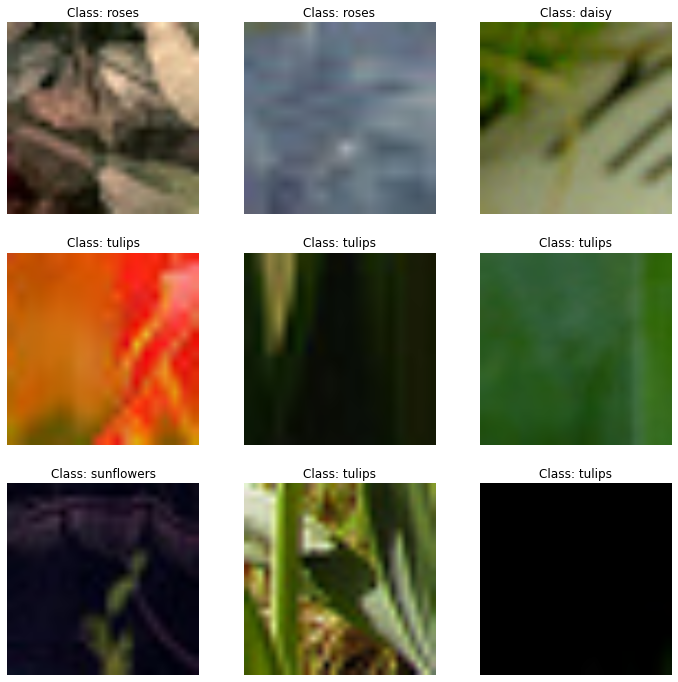

In [61]:
plt.figure(figsize = (12,12))
for X_batch , y_batch in train_set.take(1):
  for index in range(9):
    plt.subplot(3,3,index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()

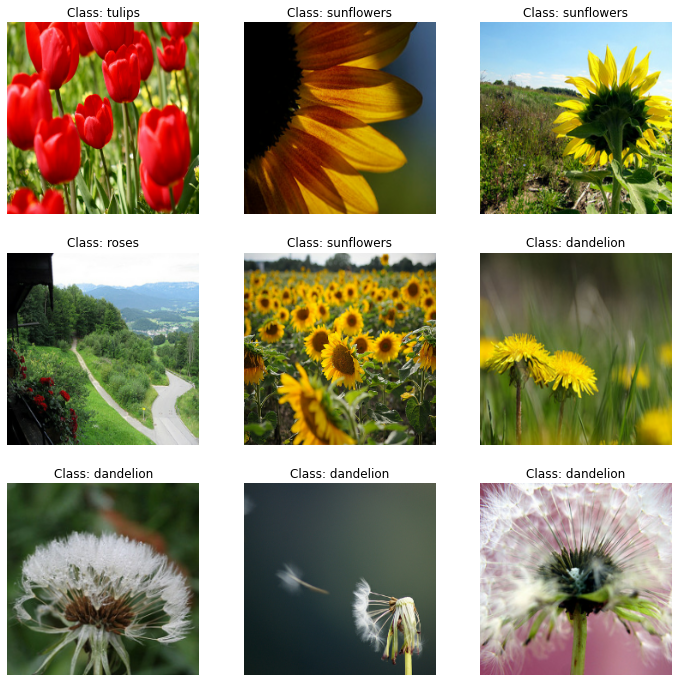

In [62]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [63]:
base_model = tf.keras.applications.xception.Xception(weights = "imagenet",include_top= False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes,activation = 'softmax')(avg)
model= tf.keras.models.Model(inputs=base_model.input,outputs=output)

83697664/83683744 [==============================] - 2s 0us/step


In [64]:
for index,layer in enumerate(base_model.layers):
  print(index,layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_42
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_43
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_44
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [65]:
for layer in base_model.layers:
  layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.2,momentum = 0.9,decay= 0.01)
model.compile(loss = "sparse_categorical_crossentropy",optimizer = optimizer , metrics = ["accuracy"])
history = model.fit(train_set,steps_per_epoch = int(0.75 * dataset_size / batch_size),
                                                    validation_data = valid_set,
                    validation_steps = int(0.12*dataset_size / batch_size),epochs = 5)

Epoch 1/5
86/86 [==============================] - 17s 158ms/step - loss: 2.7793 - accuracy: 0.3808 - val_loss: 4.2868 - val_accuracy: 0.4760
Epoch 2/5
86/86 [==============================] - 13s 155ms/step - loss: 2.3040 - accuracy: 0.4273 - val_loss: 1.3412 - val_accuracy: 0.6250
Epoch 3/5
86/86 [==============================] - 14s 158ms/step - loss: 1.8092 - accuracy: 0.4459 - val_loss: 1.6511 - val_accuracy: 0.5889
Epoch 4/5
86/86 [==============================] - 13s 153ms/step - loss: 1.5934 - accuracy: 0.4706 - val_loss: 1.3386 - val_accuracy: 0.6202
Epoch 5/5
86/86 [==============================] - 13s 152ms/step - loss: 1.5551 - accuracy: 0.4851 - val_loss: 1.3357 - val_accuracy: 0.6274


In [66]:
for layer in base_model.layers:
  layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.2,momentum = 0.9,decay= 0.01)
model.compile(loss = "sparse_categorical_crossentropy",optimizer = optimizer , metrics = ["accuracy"])
history = model.fit(train_set,steps_per_epoch = int(0.75 * dataset_size / batch_size),
                                                    validation_data = valid_set,
                    validation_steps = int(0.12*dataset_size / batch_size),epochs = 5)

Epoch 1/5
86/86 [==============================] - 16s 154ms/step - loss: 2.7061 - accuracy: 0.4172 - val_loss: 4.9940 - val_accuracy: 0.4567
Epoch 2/5
86/86 [==============================] - 13s 152ms/step - loss: 2.8643 - accuracy: 0.4230 - val_loss: 1.8962 - val_accuracy: 0.6707
Epoch 3/5
86/86 [==============================] - 14s 159ms/step - loss: 2.0567 - accuracy: 0.4666 - val_loss: 2.3283 - val_accuracy: 0.5697
Epoch 4/5
86/86 [==============================] - 13s 156ms/step - loss: 1.8021 - accuracy: 0.4815 - val_loss: 2.0512 - val_accuracy: 0.6418
Epoch 5/5
86/86 [==============================] - 13s 152ms/step - loss: 1.6497 - accuracy: 0.4826 - val_loss: 1.1314 - val_accuracy: 0.6803
